# 1. Import Libraries 

In [5]:
import glob
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
pd.set_option('display.max_columns', None)

import cv2

import Utility_functions as ut
import Custom_Evaluation as ce

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

#Skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint
from torch.utils.data import TensorDataset, DataLoader

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
from scipy.special import softmax

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearn.manifold import TSNE

import argparse
import optuna
from optuna.integration import SkorchPruningCallback

data_dir = 'C:/Dissertation/Data/'

In [6]:
%load_ext autoreload
%autoreload 2

# 2. Import Data

In [7]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'AwA2', 
                                                  VectorType = 'Binary')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom KG Extended 01" - Custom KGs with ontology alignment
#3. "Custom KG Extended 02" - Custom KGs with ontology alignment + vector combination
#4. "Word2Vec" - word2vec-google-news-300
#4. "Word2Vec Extended" - Extended Word2Vec
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)
#7. "WordNet" - WordNet Knowledge Graph (KGVec2Go WordNet)
#8. "Custom Animal Attribute KG Extended" - Extended Custom KGs

Using Resnet101 Features provided with data
Animal Attributes Included - Binary Vector
Execution time: 11.887168407440186 seconds


# 3. K means

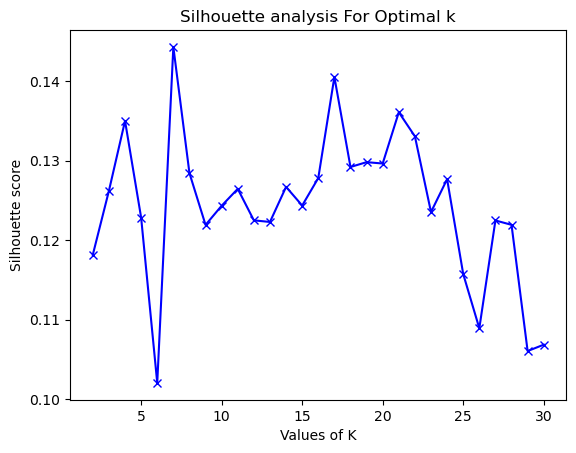

In [11]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
range_n_clusters = [2,3,4,5,6,7,8,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30]
silhouette_avg = []
for num_clusters in range_n_clusters: 
 # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(predicate_df.iloc[:,2:-18])
    cluster_labels = kmeans.labels_
 
 # silhouette score
    silhouette_avg.append(silhouette_score(predicate_df.iloc[:,2:-18], cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [12]:
labels = predicate_df['classes']

In [13]:
kmeans = KMeans(n_clusters=17, random_state=0)
kmeans.fit(predicate_df.iloc[:,2:-18])
clusters = kmeans.predict(predicate_df.iloc[:,2:-18])
clusters_df = pd.DataFrame(data = clusters
             , columns = ['K_mean'])

# 4. Visualising classes 2D space by decomposing the attributes using T-SNE

In [17]:
tsne = TSNE(n_components=2, verbose=0, random_state=100, metric = 'cosine', perplexity=15.0)
#Binary
#tsne_binary = tsne.fit_transform(binary_attributes) 
#tsne_binary_df = pd.DataFrame(data = tsne_binary
             #, columns = ['Binary comp-1', 'Binary comp-2'])

#Continous
tsne_binary= tsne.fit_transform(predicate_df.iloc[:,2:-18]) 
tsne_binary_df = pd.DataFrame(data = tsne_binary
             , columns = ['Binary comp-1', 'Binary comp-2'])

#concat
#tsne_binary_df1 = pd.concat([tsne_binary_df, labels], axis = 1)
#tsne_binary_df1 = pd.concat([tsne_binary_df1, animal_type], axis = 1)
tsne_binary_df1 = pd.concat([tsne_binary_df, labels], axis = 1)
tsne_binary_df1 = pd.concat([tsne_binary_df1, clusters_df['K_mean']], axis = 1)

In [18]:
source = tsne_binary_df1

points = alt.Chart(source).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('K_mean:N', scale=alt.Scale(scheme='Magma'))
    ).properties(
    width=800,
    height=800
)

text1 = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='classes:N'
)

text2 = points.mark_text(
    align='right',
    baseline='middle',
    dx=-10
).encode(
    text='K_mean:N'
)

points.interactive() + text1 + text2

alt.LayerChart(...)